## Giới thiệu
Trong dự án này, chúng ta sẽ phân tích sự ảnh hưởng của địa điểm đến giá chung cư, tìm hiểu về sự phân số lượng chung cư ở từng phân khúc giá và sử dụng một mô hình học sâu (Deep Learning) để dự đoán giá chung cư ở Thành phố Hồ Chí Minh. Dữ liệu đầu vào bao gồm các thông tin như diện tích, số phòng ngủ, số phòng tắm, địa chỉ, và phân tích theo các phân khúc giá. Mục tiêu chính là xây dựng một mô hình chính xác để hỗ trợ trong việc ước tính giá trị bất động sản.

### 1. Import các thư viện cần dùng

In [21]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### 2. Lấy dữ liệu từ database

In [22]:
from sklearn.preprocessing import LabelEncoder

database_name = "your_database_name"

connection = psycopg2.connect(
    dbname=database_name,
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432" 
)

query = "SELECT * FROM chung_cu"

# Đọc dữ liệu từ database
df = pd.read_sql_query(query, connection)

# Mã hóa 'Địa chỉ'
le = LabelEncoder()
df["Địa chỉ_encoded"] = le.fit_transform(df["Địa chỉ"])

# Đóng kết nối
connection.close()

### 3. Phân tích ảnh hưởng của địa điểm đến giá chung cư

In [23]:
from scipy.stats import f_oneway

# Tách giá theo từng địa điểm
groups = [group["Giá(tỷ)"].values for name, group in df.groupby("Địa chỉ")]

# Thực hiện ANOVA
f_stat, p_value = f_oneway(*groups)
print("F-statistic:", f_stat)
print("P-value:", p_value)

if p_value < 0.05:
    print("Kết luận: Có sự khác biệt giá đáng kể giữa các địa điểm.")
else:
    print("Kết luận: Không có sự khác biệt giá đáng kể giữa các địa điểm.")


F-statistic: 58.55865067393487
P-value: 4.847150994529654e-224
Kết luận: Có sự khác biệt giá đáng kể giữa các địa điểm.


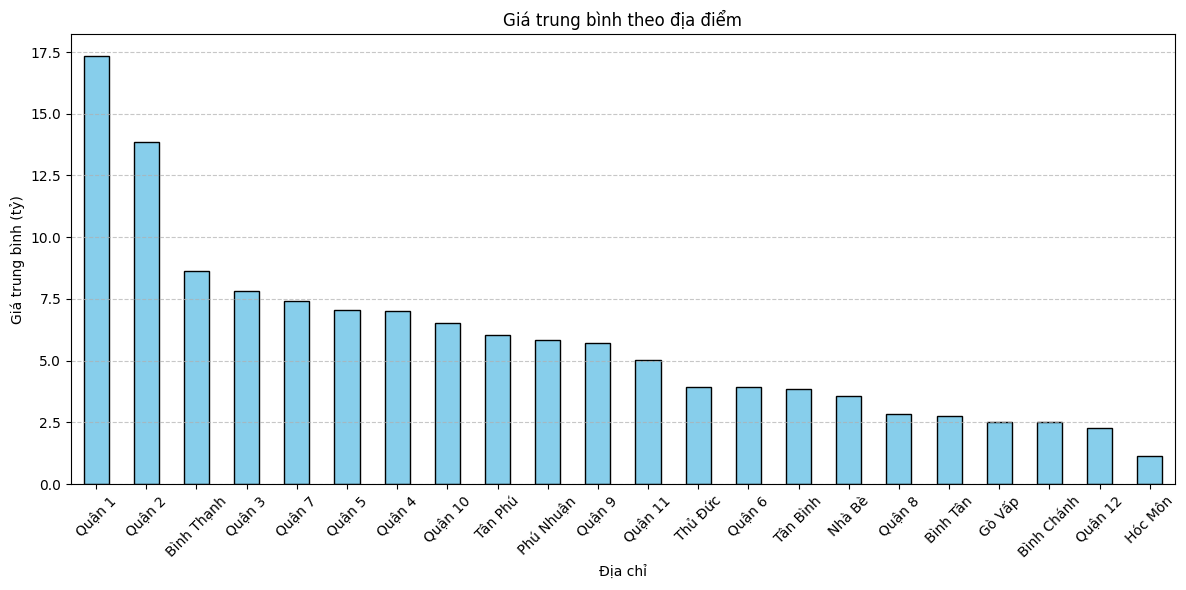

In [24]:
avg_price_by_location = df.groupby("Địa chỉ")["Giá(tỷ)"].mean().sort_values(ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
avg_price_by_location.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Giá trung bình theo địa điểm")
plt.xlabel("Địa chỉ")
plt.ylabel("Giá trung bình (tỷ)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 4. Tìm hiểu về số lượng chung cư ở các phân khúc

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Tạo cột phân loại
df["Phân khúc"] = pd.cut(df["Giá(tỷ)"], bins=[0, 2, 5, 20], labels=["Bình dân", "Trung cấp", "Cao cấp"])

# Kiểm tra và xử lý giá trị NaN
df = df.dropna()  # Loại bỏ các hàng chứa NaN

# Chuẩn bị dữ liệu
X = df[["Diện tích(m2)", "Phòng ngủ", "Phòng tắm"]]
y = df["Phân khúc"]

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện mô hình
model = GradientBoostingClassifier(
    n_estimators=200,        # Tăng số lượng cây (default=100)
    learning_rate=0.05,      # Điều chỉnh tốc độ học (default=0.1)
    max_depth=4,             # Độ sâu tối đa của mỗi cây (default=3)
    subsample=0.8,           # Sử dụng 80% dữ liệu cho mỗi cây (default=1.0)
    random_state=42
)
model.fit(X_train, y_train)

# Dự đoán và báo cáo
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Bình dân       0.61      0.33      0.42        86
     Cao cấp       0.82      0.73      0.77       528
   Trung cấp       0.68      0.81      0.74       516

    accuracy                           0.74      1130
   macro avg       0.70      0.62      0.65      1130
weighted avg       0.74      0.74      0.73      1130



#### **Giải thích các thông số trong kết quả Classification Report**

##### **1. Precision**
- **Định nghĩa**: Tỷ lệ giữa số dự đoán đúng trên tổng số dự đoán của mô hình cho một lớp.
- **Ý nghĩa**: Cho biết trong số các mẫu được dự đoán thuộc một lớp cụ thể, bao nhiêu phần trăm là chính xác.
- **Công thức**:  
  $
  \text{Precision} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}}
  $

##### **2. Recall**
- **Định nghĩa**: Tỷ lệ giữa số dự đoán đúng trên tổng số mẫu thực tế thuộc một lớp.
- **Ý nghĩa**: Cho biết mô hình phát hiện đúng bao nhiêu phần trăm mẫu thực tế của một lớp.
- **Công thức**:  
  $
  \text{Recall} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}
  $

##### **3. F1-Score**
- **Định nghĩa**: Là trung bình điều hòa của Precision và Recall.
- **Ý nghĩa**: Tổng hợp hiệu suất của Precision và Recall trong một giá trị duy nhất.
- **Công thức**:  
  $
  \text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  $

##### **4. Support**
- **Định nghĩa**: Số lượng mẫu thực tế thuộc mỗi lớp.
- **Ý nghĩa**: Cho biết kích thước dữ liệu thực tế của mỗi lớp, dùng để đánh giá độ cân bằng của tập dữ liệu.

##### **5. Accuracy**
- **Định nghĩa**: Tỷ lệ tổng số dự đoán đúng trên tổng số mẫu.
- **Công thức**:  
  $
  \text{Accuracy} = \frac{\text{Số dự đoán đúng}}{\text{Tổng số mẫu}}
  $

##### **6. Macro Avg**
- **Định nghĩa**: Trung bình cộng Precision, Recall, và F1-Score trên tất cả các lớp.
- **Ý nghĩa**: Đánh giá hiệu suất trung bình trên các lớp mà không xét đến kích thước mỗi lớp (không trọng số).

##### **7. Weighted Avg**
- **Định nghĩa**: Trung bình có trọng số của Precision, Recall, và F1-Score, dựa trên số lượng mẫu trong mỗi lớp.
- **Ý nghĩa**: Đánh giá tổng thể mô hình có xét đến kích thước từng lớp.

In [26]:
# Vẽ biểu đồ phân tán
def draw_scatter_plot(df, x, y, hue, palette="viridis", s=100, alpha=0.8):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df,
        x=x,
        y=y,
        hue=hue,
        palette=palette,
        s=s,
        alpha=alpha
    )

    # Tuỳ chỉnh biểu đồ
    plt.title(f"{y} theo {x} và {hue}", fontsize=16)
    plt.xlabel(x, fontsize=14)
    plt.ylabel(y, fontsize=14)
    plt.legend(title=hue, fontsize=12, title_fontsize=13)
    plt.grid(True)
    plt.show()

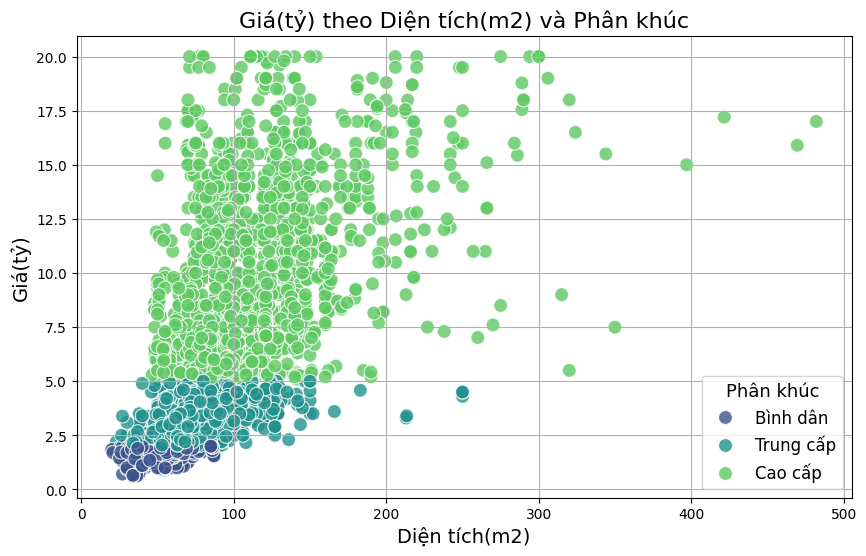

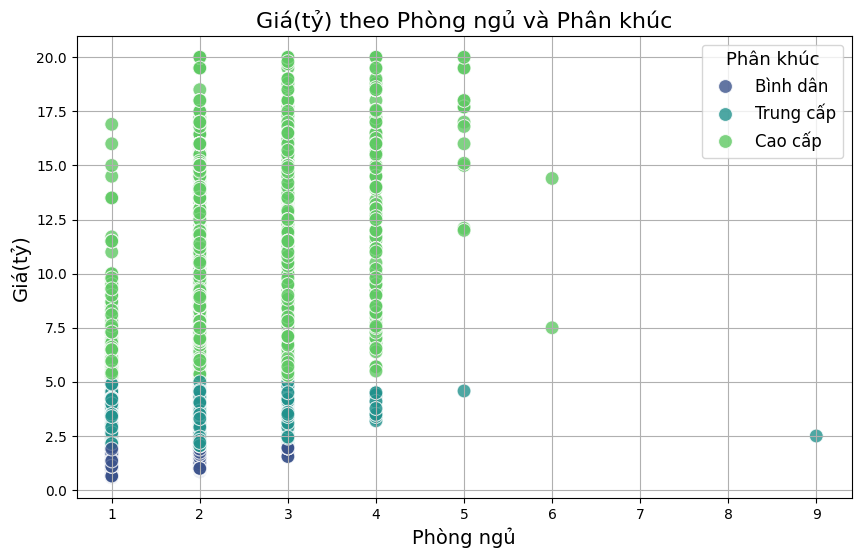

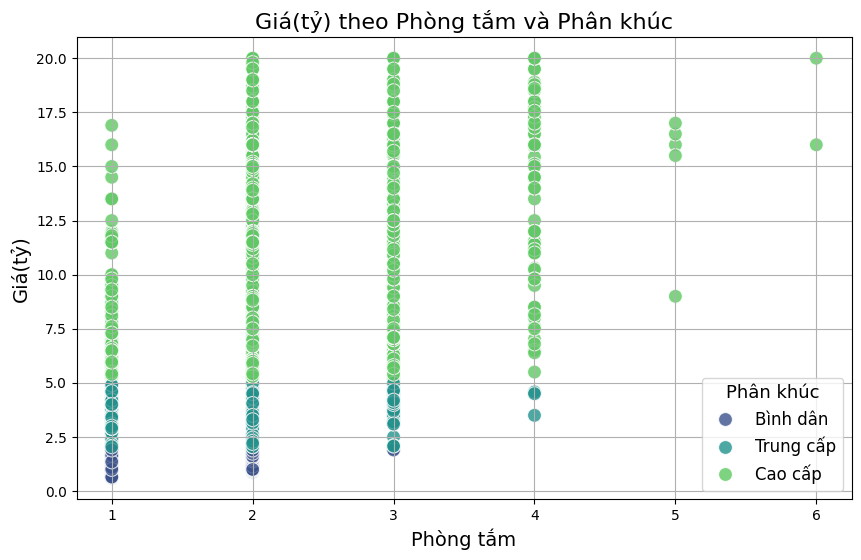

In [27]:
draw_scatter_plot(df, "Diện tích(m2)", "Giá(tỷ)", "Phân khúc")
draw_scatter_plot(df, "Phòng ngủ", "Giá(tỷ)", "Phân khúc")
draw_scatter_plot(df, "Phòng tắm", "Giá(tỷ)", "Phân khúc")

### 5. Tạo mô hình dự đoán giá chung cư
Sử dụng TensorFlow để xây dựng một mạng neural đơn giản với các bước chính:
- Chuẩn hóa dữ liệu đầu vào.
- Xây dựng mô hình với một số lớp ẩn để học các mối quan hệ phức tạp.
- Biên dịch mô hình với hàm mất mát Mean Squared Error (MSE) và trình tối ưu Adam.
- Huấn luyện mô hình trên tập dữ liệu đã xử lý.

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Chọn các cột cần thiết
features = ["Diện tích(m2)", "Phòng ngủ", "Phòng tắm", "Địa chỉ_encoded"]
target = "Giá(tỷ)"

X = df[features].values
y = df[target].values

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [29]:
# Xây dựng mô hình
model = Sequential([
    Dense(32, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.2),  # Dropout 20% số lượng kết nối
    Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(1)
])


# Biên dịch mô hình
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [30]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1)

# Đánh giá mô hình
loss, mae = model.evaluate(X_test, y_test)
print(f"Mean Absolute Error (MAE): {mae}")

Epoch 1/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 45.4261 - mae: 5.3584 - val_loss: 19.0410 - val_mae: 2.8947
Epoch 2/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.7145 - mae: 2.9366 - val_loss: 15.0249 - val_mae: 2.7794
Epoch 3/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.2600 - mae: 2.8612 - val_loss: 13.9168 - val_mae: 2.6280
Epoch 4/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.8531 - mae: 2.7394 - val_loss: 13.2619 - val_mae: 2.5085
Epoch 5/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.5316 - mae: 2.5283 - val_loss: 12.6659 - val_mae: 2.4504
Epoch 6/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.1971 - mae: 2.5671 - val_loss: 12.3358 - val_mae: 2.4020
Epoch 7/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.2054 - mae: 2.4792 - val_loss: 12.2908 - val_mae: 2.3291
Epoch 8/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.9697 - mae: 2.4153 - val_loss: 11.6463 - val_mae: 2.3109
Epoch 9/100
142/142 ━━━━━━━━━━━━

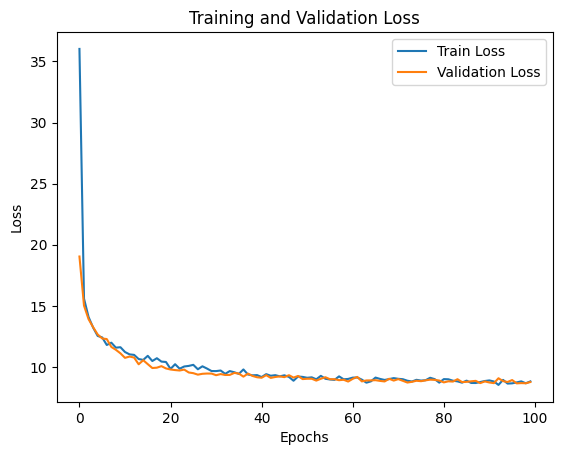

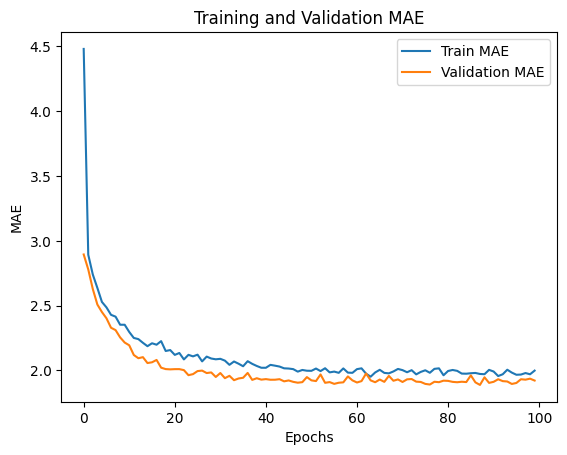

In [31]:
# Vẽ đồ thị Loss trong quá trình huấn luyện
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Vẽ đồ thị MAE trong quá trình huấn luyện
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [35]:
# Dự đoán giá trên tập kiểm tra
y_pred = model.predict(X_test)

# So sánh giá trị thực tế và dự đoán
comparison_df = pd.DataFrame({"Giá thực tế(tỷ)": y_test, "Giá dự đoán(tỷ)": y_pred.flatten()})
print(comparison_df)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
      Giá thực tế(tỷ)  Giá dự đoán(tỷ)
0                2.24         3.282506
1                3.75         4.598887
2                5.65         7.894773
3               12.00         5.036883
4                5.20         5.535218
...               ...              ...
1125             2.45         3.323976
1126             6.10         5.029986
1127             5.10         6.362800
1128             6.60         4.598887
1129             7.00         7.171515

[1130 rows x 2 columns]


In [33]:
def input_data():
    dien_tich = float(input("Nhập diện tích (m²): "))
    phong_ngu = int(input("Nhập số phòng ngủ: "))
    phong_tam = int(input("Nhập số phòng tắm: "))
    dia_chi = input("Nhập địa chỉ: ")
    return [[dien_tich, phong_ngu, phong_tam, dia_chi]]

def encode_adress(data):
    data[0][-1] = df[df['Địa chỉ'] == data[0][-1]]['Địa chỉ_encoded'].values[0]
    return data

# Thông tin đầu vào
new_data = input_data()
encoded_data = encode_adress(new_data)

# Chuẩn hóa dữ liệu đầu vào
encoded_data_scaled = scaler.transform(encoded_data)

# Dự đoán giá
predicted_price = model.predict(encoded_data_scaled)

# Hiển thị kết quả
print(f"Dự đoán giá bất động sản: {predicted_price[0][0]:.2f} tỷ VNĐ")

filtered_df = df[(df['Địa chỉ_encoded'] == encoded_data[0][-1]) &
                 (df['Diện tích(m2)'] >= encoded_data[0][0] - 10) &
                 (df['Diện tích(m2)'] <= encoded_data[0][0] + 10) &
                 (df['Phòng ngủ'] == encoded_data[0][1]) &
                 (df['Phòng tắm'] == encoded_data[0][2])].head()

# In ra dữ liệu thực tế
print("Dữ liệu thực tế với các điều kiện đầu vào:")
print(filtered_df[["Giá(tỷ)", "Diện tích(m2)", "Phòng ngủ", "Phòng tắm", "Địa chỉ", "Phân khúc"]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Dự đoán giá bất động sản: 6.46 tỷ VNĐ
Dữ liệu thực tế với các điều kiện đầu vào:
      Giá(tỷ)  Diện tích(m2)  Phòng ngủ  Phòng tắm  Địa chỉ  Phân khúc
3898      3.2           71.3          2          1  Quận 10  Trung cấp
5780      2.9           74.1          2          1  Quận 10  Trung cấp


## Kết luận
Mô hình Deep Learning đã cho thấy khả năng dự đoán giá bất động sản khá tốt, mặc dù vẫn còn một số điểm cần cải thiện. Dưới đây là các kết quả chính:
- Mô hình đã học được mối quan hệ giữa diện tích, số phòng ngủ, số phòng tắm và giá trị bất động sản.
- Các phân khúc giá được phân loại một cách hợp lý, hỗ trợ người dùng trong việc đưa ra quyết định mua bán.